# Double-Stack BERT Pretraining

In this notebook, we will do our first steps to process inputs using SBERT (https://arxiv.org/abs/1908.10084) and pretrain the sentence modeling model using RoBERTa. Here's the general view of what we're gonna do in this pretraining phase.

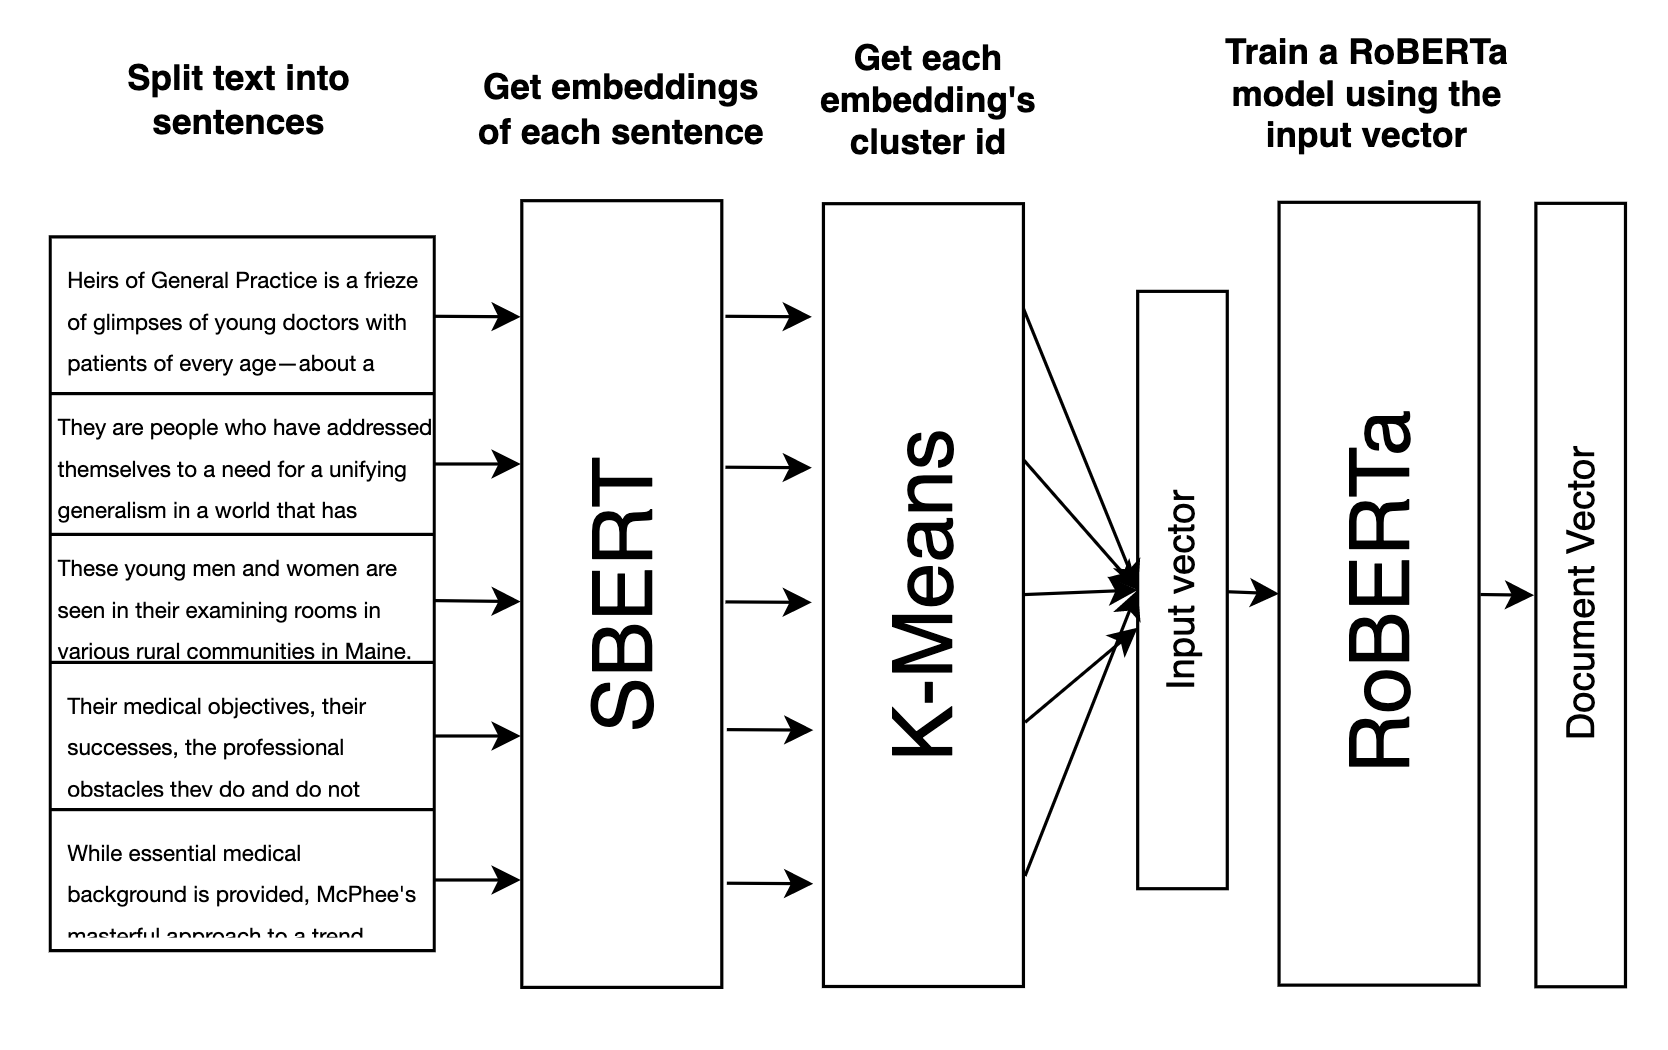

In [ ]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import os
from tqdm.auto import tqdm
from datasets import load_dataset
import re
from scipy.cluster.vq import *
import torch
import torch.nn as nn
import torch.optim as optim
import math
import json
from transformers import RobertaConfig
from transformers import RobertaForMaskedLM
from transformers import AdamW

## Data Preparation

We're going to load the dataset from BookCorpus using huggingface library.

In [ ]:
# Load the dataset from Book Corpus datasets
# This function takes the parameter isDummyData which will return only 1000 data points if it were true. The default is True
# library dependencies: 
def load_data():
  # This dataset has 74_004_228 rows
  dataset = load_dataset('bookcorpus')
  text_data = []
  len_text_data = 0
  for sample in tqdm(dataset['train']):
    sample = sample['text'].replace('\n', '')
    text_data.append(sample)
    # len_text_data += 1
    # if len_text_data == 10_000:
    #     break
  return text_data

In [ ]:
dataset = load_data()

0 examples [00:00, ? examples/s]

### Splitting text into sentences and getting their embeddings

In [ ]:
# splitting text into sentences
# receives a string as parameter
# returns an array of string(s)
# library dependencies: re
def splitTextToSentences(text):
  try:
    arrayOfSentences = re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', text)
  except:
    arrayOfSentences = [""]
  return arrayOfSentences

# Turns an array of raw text into each of it sentences embedding
# receives a pretrained Sentence-BERT model and the intended dataset
# returns 2D array. Each index contains a list of embedded strings
# library dependencies: sentence_transformers
# local function dependencies: splitTextToSentences  
def getSentencesEmbedding(sentenceTransformer, dataset):
  # splitting eaxh text of the dataset into a list of sentences using previously made function
  sentences_dataset = [splitTextToSentences(text) for text in dataset]
  dataset_embeddings = []
  for i in range(len(sentences_dataset)):
    embeddings = sentenceTransformer.encode(sentences_dataset[i])
    dataset_embeddings.append(embeddings)

  return dataset_embeddings

We're using the sentence_transformer library for the application of SBERT. At the time, the best general model is the 'all-mpnet-base-v2' (sbert.net)

In [ ]:
# load the Sentence-BERT model
sbert_model = SentenceTransformer('all-mpnet-base-v2')

In [ ]:
# gets each document with its sentences 
embeddings = getSentencesEmbedding(sbert_model, dataset)
np.save('embeddings.npy', embeddings)

### Training the K-means codebook to map sentences into cluster id

In [ ]:
# Clustering sentences into with kmeans(param1,param2,param3)
# param1 => array input, param2 => number of k, param3 => iteration, optional, default = 20
# would act as the merge file
vocab_size = 100
codebook,_ = kmeans(np.vstack(embeddings), vocab_size, 20)

### Making the dictionary vocabs

With special RoBERTa tokens.

In [ ]:
# Making the vocabs.json
# RoBERTa special tokens '<s>', '<pad>', '</s>', '<unk>', '<mask>', no CLS token
vocabs = {'<s>': 0, '<pad>': 1, '</s>': 2, '<unk>': 3, '<mask>':4, }
for i in range(codebook.shape[0]):
  w = str(i)
  vocabs[w] = i + 5

Saving the tokenizer components (codebook and dictionary vocabs)

In [ ]:
# save this as 'vocabs.json'
tokenizer_path = 'docbert_tokenizer'
if not os.path.exists(tokenizer_path):
  os.mkdir(tokenizer_path)
np.save(tokenizer_path + '/codebook.npy', codebook)
with open(tokenizer_path + '/vocabs.json', 'w') as outfile:
    json.dump(vocabs, outfile)

### Formatting the input to use in Masked-Language Modeling for RoBERTa

The input will consists of labels, mask, and input_ids.

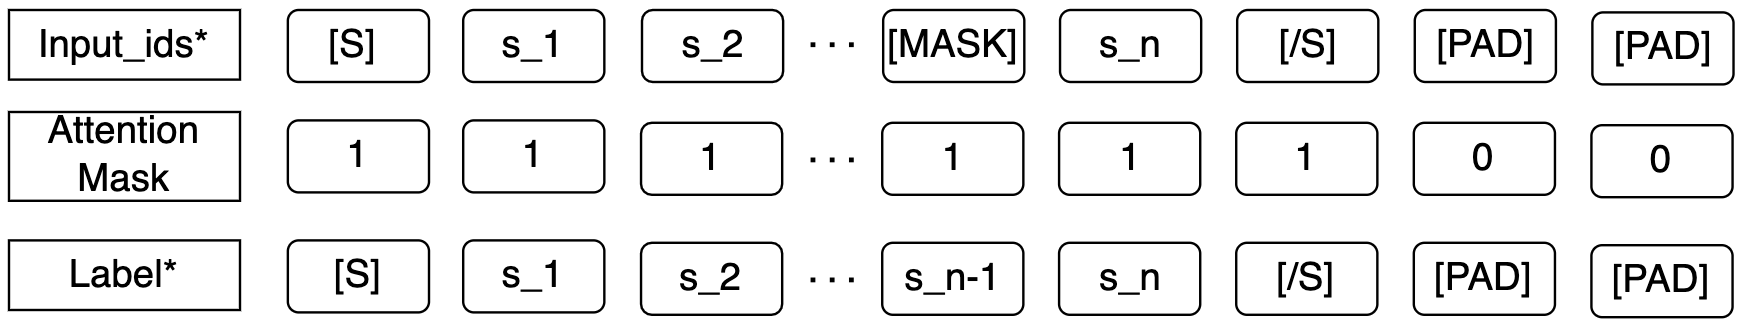

In [ ]:
# function to turn arrays of sentence embedding into appropriate inputs
def tokenize(doc_embeddings, vocabs, codebook, max_length= -1, padding = True, truncation = True): 
  docs_tokens = []
  for doc in doc_embeddings:
    sentences_cluster_ids = vq(doc,codebook)
    sentences_token_ids = []
    attention_mask = []
    for cluster_id in sentences_cluster_ids[0]: 
      sentences_token_ids.append(vocabs[str(cluster_id)])

    if truncation and max_length != -1 :
      if len(sentences_token_ids) + 2 > max_length:
        sentences_token_ids = sentences_token_ids[:(max_length-2)]
        padding = False

    input_ids = [vocabs['<s>']] + sentences_token_ids + [vocabs['</s>']]
    attention_mask.extend([1] * len(input_ids))

    if padding:
      padding_len = max_length - len(input_ids)
      input_ids.extend([vocabs['<pad>']] * padding_len)
      attention_mask.extend([0] * padding_len)

    docs_tokens.append({'input_ids':input_ids, 'attention_mask':attention_mask})
  
  return docs_tokens

In [ ]:
batch = tokenize(embeddings, vocabs, codebook, max_length=512, padding=True, truncation=True)

labels = torch.tensor([x['input_ids'] for x in batch])
mask = torch.tensor([x['attention_mask'] for x in batch])
# make copy of labels tensor, this will be input_ids
input_ids = labels.detach().clone()
# create random array of floats with equal dims to input_ids
rand = torch.rand(input_ids.shape)
# mask random 15% where token is not 0 <s>, 1 <pad>, or 2 </s>
mask_arr = (rand < .15) * (input_ids != 0) * (input_ids != 1) * (input_ids != 2)
# loop through each row in input_ids tensor (cannot do in parallel)
for i in range(input_ids.shape[0]):
  # get indices of mask positions from mask array
  selection = torch.flatten(mask_arr[i].nonzero()).tolist()
  # mask input_ids
  input_ids[i, selection] = 4  # our custom <mask> token == 4

In [ ]:
#Dataloader class 
class Dataset(torch.utils.data.Dataset):
  def __init__(self, encodings):
      # store encodings internally
      self.encodings = encodings

  def __len__(self):
      # return the number of samples
      return self.encodings['input_ids'].shape[0]

  def __getitem__(self, i):
      # return dictionary of input_ids, attention_mask, and labels for index i
      return {key: tensor[i] for key, tensor in self.encodings.items()}

In [ ]:
encodings = {'input_ids': input_ids, 'attention_mask': mask, 'labels': labels}
data = Dataset(encodings)
loader = torch.utils.data.DataLoader(data, batch_size=16, shuffle=True)

## Pre-training RoBERTa

Let's train the RoBERTa using previously processed input.

In [ ]:
vocab_size = 104
config = RobertaConfig(
    vocab_size= vocab_size,  # we align this to the tokenizer vocab_size
    max_position_embeddings=514,
    hidden_size=768,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1
)
model = RobertaForMaskedLM(config)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# # and move our model over to the selected device
model.to(device)

In [ ]:
# activate training mode
model.train()
# initialize optimizer
optim = AdamW(model.parameters(), lr=1e-4)
epochs = 2

for epoch in range(epochs):
    # setup loop with TQDM and dataloader
    loop = tqdm(loader, leave=True)
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all tensor batches required for training
        inputIds = batch['input_ids'].to(device)
        attentionMask = batch['attention_mask'].to(device)
        labels_train = batch['labels'].to(device)
        # process
        outputs = model(inputIds, attention_mask=attentionMask,labels=labels_train)
        # extract loss
        loss = outputs.loss
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

In [ ]:
model.save_pretrained(root_path + 'docberta_dummy')